## Getting started with XGBoost

### What is XGBoost?

XGBoost stands for Extreme Gradient Boosting, it is a performant machine learning library based on the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. XGBoost implements a Gradient Boosting algorithm based on decision trees.

This tutorial was originally posted by Cambridge Spark: https://cambridgespark.com/content/tutorials/getting-started-with-xgboost/index.html

### The gradient boosting algorithm

If you are already familiar with Random Forests, the Gradient Boosting algorithm implemented in XGBoost is also an ensemble of decision trees. Those trees are poor models individually, but when they are grouped they can be really performant.

The difference between XGBoost and Random Forest lies in the way those trees are built and combined. Random Forest builds **fully grown** decision trees in parallel on subsamples of the data. Each tree is higly specialized to predict on its subsample and do not generalize well (**high variance**). By combining the predictions made by each individual tree, the Random Forest algorithm decreases variance and gives good performance.

XGBoost on the other hand, builds really **short and simple** decision trees iteratively. Each tree is called a “weak learner” for their high bias. XGBoost starts by creating a first simple tree which has poor performance by itself. It then builds another tree which is trained to predict what the first tree was not able to, and is itself a weak learner too. The algorithm goes on by sequentially building more weak learners, each one correcting the previous tree until a stopping condition is reached, such as the number of trees (estimators) to build.

### Why should you learn to use XGBoost?

XGBoost is widely used in Machine Learning and got particularly famous on Kaggle, the machine learning competition website. As Anthony Goldbloom CEO of Kaggle said back in 2016, when XGBoost was becoming big in competitive Machine Learning:

It has almost always been ensembles of decision trees that have won competitions. It used to be random forest that was the big winner, but over the last six months a new algorithm called XGboost has cropped up, and it’s winning practically every competition in the structured data category.

XGBoost has shown a great track record of high performances on problems involving structured data and thus should be part of your data scientist toolbox, even more so if you are willing to compete on Kaggle. Apart from its performance, XGBoost is also recognized for its flexibility and speed. Whilst gradient boosting requires to build trees one by one sequentially, XGBoost implements a way to parallelize the training of each tree, making the training faster and the job of Data Scientists easier. XGBoost can be used with a simple SKlearn API (used in this tutorial) or a more flexible native API (used in the upcoming advanced tutorial). It is also available for other languages such as R, Java, Scala, C++, etc. and can run on distributed environments such as Hadoop and Spark.

A word of warning before going further with the tutorial, as it is well known, there is no free lunch in Machine Learning, and XGBoost is no exception to this rule. It can sometimes be harder to tune or have a higher tendency to overfitting than a simpler model such as Random Forest and perform poorly with non structured data. 不適合低結構化數據



### Presentation of the dataset and problem

The data used for this tutorial can be downloaded online: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

This dataset contains information about credit card owners in Taiwan. It contains some demographics features, past payments, bills amount, etc. The last column is the target, whether or not the customer will default payment on the next month. Here is a more thorough description of the features:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

X4: Marital status (1 = married; 2 = single; 3 = others).

X5: Age (year).

X6 — X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

### First round of training

**Quick processing**

In [1]:
# Use pandas to load the data in a dataFrame
import pandas as pd
df = pd.read_excel('./_data/default of credit card clients.xls', header=1, index_col=0) # conda install xlrd
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [2]:
df.shape

(30000, 24)

As it happens sometimes with public datasets, the data is not perfectly clean and some columns have unexpected values, some customers have an education equal to 5 or 6, which does not map to anything, or a payment status equal to -2… Usually those inconsistencies should be investigated and cleaned, but since the focus of this tutorial is on xgboost, we will just remove them from our dataset 重點不在此，故直接移除

In [3]:
import numpy as np
def clean_dataset(df):
    df.loc[~df.EDUCATION.isin([1,2,3,4]), "EDUCATION"] = np.nan
    for i in [0,2,3,4,5,6]:
        df.loc[df['PAY_{}'.format(i)]<-1] = np.nan
    df.dropna(inplace=True)
clean_dataset(df)
df.shape

(23188, 24)

Some features are categorical so we will need to create dummy variables before passing the data to xgboost. This is easily done with pandas’ get_dummies method.

In [4]:
def process_categorical_features(df):
    dummies_education = pd.get_dummies(df.EDUCATION, prefix="EDUCATION", drop_first=True)
    dummies_marriage = pd.get_dummies(df.MARRIAGE, prefix="MARRIAGE", drop_first=True)
    df.drop(["EDUCATION", "MARRIAGE"], axis=1, inplace=True)
    return pd.concat([df, dummies_education, dummies_marriage], axis=1)
df = process_categorical_features(df)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,EDUCATION_2.0,EDUCATION_3.0,EDUCATION_4.0,MARRIAGE_1.0,MARRIAGE_2.0,MARRIAGE_3.0
ID,,,,,,,,,,,,,,,,,,,,,
2,120000.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,...,1000.0,0.0,2000.0,1.0,True,False,False,False,True,False
3,90000.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,...,1000.0,1000.0,5000.0,0.0,True,False,False,False,True,False
4,50000.0,2.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,46990.0,...,1100.0,1069.0,1000.0,0.0,True,False,False,True,False,False
5,50000.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,0.0,8617.0,...,9000.0,689.0,679.0,0.0,True,False,False,True,False,False
6,50000.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,64400.0,...,1000.0,1000.0,800.0,0.0,False,False,False,False,True,False


We dropped columns EDUCATION and MARRIAGE to replace them by dummy variables, encoding each possible value. We do not need to do it for SEX as it is already a binary variable. The encoding for the payment variables (PAY_N) is not perfect either, as a positive number refers to the number of months late and -1 refers to a payment in due time. Ideally, we should process it too, but we will assume here that it means the payment was done the month before, so the continuous variable makes sense.

### Prepare training and test datasets

Let’s extract the target from the features

In [5]:
y = df['default payment next month']
X = df[[col for col in df.columns if col!="default payment next month"]]

The function train_test_split from sklearn allows easy random split of a dataset

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25, random_state=42)
print("Size of train dataset: {} rows".format(X_train.shape[0]))
print("Size of test dataset: {} rows".format(X_test.shape[0]))

Size of train dataset: 17391 rows
Size of test dataset: 5797 rows


**Ready to train!**

In [7]:
import xgboost as xgb # conda install -c anaconda py-xgboost

For this tutorial, we are going to use the sklearn API of xgboost, which is easy to use and can fit in a large machine learning pipeline using other models from the scikit-learn library

We set nthread to -1 to tell xgboost to use as many threads as available to build trees in parallel.

In [8]:
classifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=42)

Let’s train a model with the default parameters. We will learn in a future tutorial how to select the best hyperparameters to improve accuracy.

In [9]:
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

### Evaluation

Let’s use our trained model to predict whether the customers from the test set will default or not and evaluate the accuracy of our model.

In [10]:
predictions = classifier.predict(X_test)

Predictions are returned in a numpy array. Let’s convert it to a DataFrame for better visualisation

In [11]:
pd.DataFrame(predictions, index=X_test.index, columns=['Predicted default']).head()

,Predicted default
ID,
5531,0
19730,0
22901,1
23794,0
17749,0


We predict that customers #5531 will not default payment next month, whilst customer #22901 will default.

In [12]:
pd.DataFrame(y_test).head()

,default payment next month
ID,
5531,0.0
19730,0.0
22901,1.0
23794,0.0
17749,0.0


Looking at the true default outcome, it turns out our model is right for those 5 first customers!

Let’s use the score xgboost method to see how accurate our model is for all test customers:

In [13]:
print("Model Accuray: {:.2f}%".format(100*classifier.score(X_test, y_test)))

Model Accuray: 81.71%


We get a decent accuracy over 80%.

But as a good data scientist, you should take it with a pinch of salt. The problem we are working on here is unbalanced 不平衡問題: most of the people do not default payments and the customers who default are rare in our dataset. This means that by predicting that none of the customers will default, we could get a good accuracy too, even though the model would be useless. There are ways to prevent our model to make such mistakes.

#### Handy XGBoost methods

XGBoost comes with a set of handy methods to better understand your model

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

The plot_importance function allows to see the relative importance of all features in our model. Here we see that BILL_AMT1 and LIMIT_BAL are the most important features whilst sex and education seem to be less relevant

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

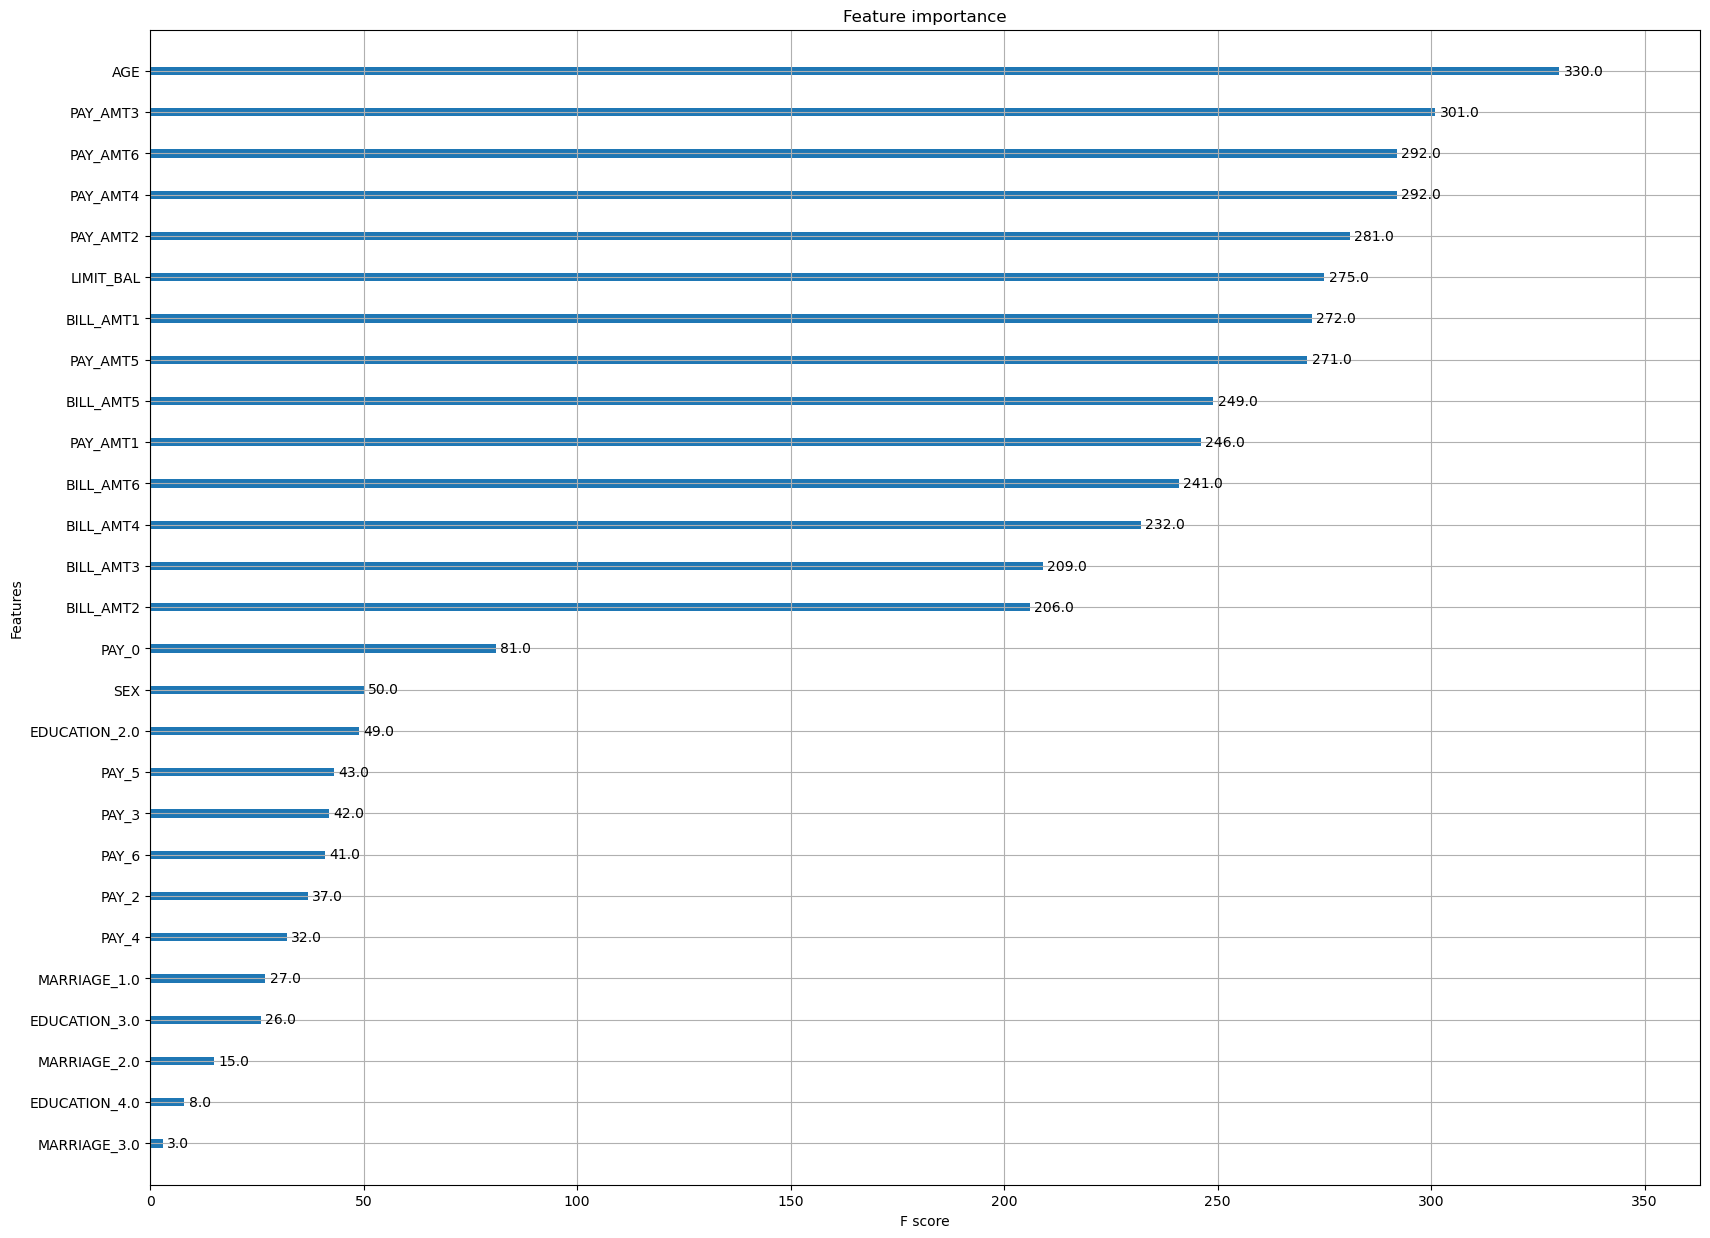

In [15]:
plt.figure(figsize=(20,15))
xgb.plot_importance(classifier, ax=plt.gca())

plot_tree allows to visualize the trees that were built by XGBoost

<Axes: >

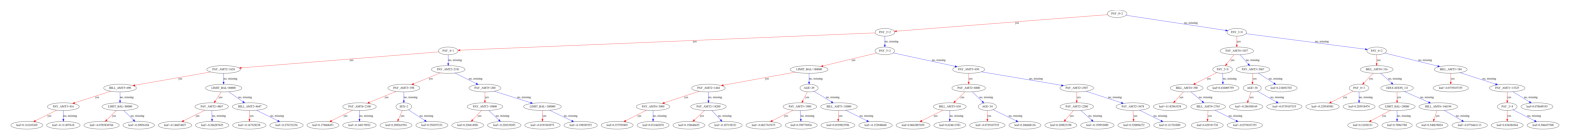

In [16]:
plt.figure(figsize=(20,15))
# pip install graphviz (python-graphviz and graphviz-2.36.0.pkg), conda install graphviz seems useless
xgb.plot_tree(classifier, ax=plt.gca())

You can also access the characteristics of your model

In [17]:
print("Number of boosting trees: {}".format(classifier.n_estimators))
print("Max depth of trees: {}".format(classifier.max_depth))
print("Objective function: {}".format(classifier.objective))

Number of boosting trees: None
Max depth of trees: None
Objective function: binary:logistic


As you can see, there are many parameters that define your model. Those parameters can be set before training, and selecting the good values will boost the performance of your model. We go through ways of doing so in the next tutorial.

#### Reference:

- https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients
- https://blog.cambridgespark.com/getting-started-with-xgboost-3ba1488bb7d4